In [1]:
from PIL import Image
from  matplotlib import pyplot as plt
import seaborn as sns
import tensorflow as tf
import numpy as np
import time
import pandas as pd
import os

In [2]:
import random
import sys
from sklearn.model_selection import train_test_split

In [3]:
import tflearn
from tflearn.layers.core import input_data, dropout, fully_connected, flatten
from tflearn.layers.conv import conv_2d, max_pool_2d, avg_pool_2d
from tflearn.layers.merge_ops import merge
from tflearn.layers.normalization import local_response_normalization
from tflearn.layers.estimator import regression

curses is not supported on this machine (please install/reinstall curses for an optimal experience)


In [4]:
import cv2

In [5]:
df = pd.read_csv('fer2013/fer2013.csv')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
emotion    35887 non-null int64
pixels     35887 non-null object
Usage      35887 non-null object
dtypes: int64(1), object(2)
memory usage: 841.2+ KB


In [7]:
df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [8]:
pic = np.array([int(i) for i in df['pixels'][0].split(' ')]).reshape((48,48))

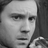

In [9]:
pic = pic.astype(np.uint8)
Image.fromarray(pic)

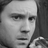

In [10]:
data_image = np.fromstring(str(df['pixels'][0]), dtype=np.uint8, sep=' ').reshape((48, 48))
Image.fromarray(data_image)

In [11]:
SIZE_FACE = 48
EMOTIONS = ['angry', 'disgusted', 'fearful',
            'happy', 'sad', 'surprised', 'neutral']
SAVE_DIRECTORY = 'emo_data'
SAVE_MODEL_FILENAME = 'Gudi_model_100_epochs_20000_faces'
DATASET_CSV_FILENAME = 'fer2013.csv'
SAVE_DATASET_IMAGES_FILENAME = 'data_images.npy'
SAVE_DATASET_LABELS_FILENAME = 'data_labels.npy'

In [12]:
pic

array([[ 70,  80,  82, ...,  52,  43,  41],
       [ 65,  61,  58, ...,  56,  52,  44],
       [ 50,  43,  54, ...,  49,  56,  47],
       ...,
       [ 91,  65,  42, ...,  72,  56,  43],
       [ 77,  82,  79, ..., 105,  70,  46],
       [ 77,  72,  84, ..., 106, 109,  82]], dtype=uint8)

In [13]:
cascade_classifier = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

In [ ]:
def format_image(image):
    if len(image.shape) > 2 and image.shape[2] == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        image = cv2.imdecode(image, cv2.CV_LOAD_IMAGE_GRAYSCALE)
    gray_border = np.zeros((150, 150), np.uint8)
    gray_border[:, :] = 200
    gray_border[
        int((150 / 2) - (SIZE_FACE / 2)): int((150 / 2) + (SIZE_FACE / 2)),
        int((150 / 2) - (SIZE_FACE / 2)): int((150 / 2) + (SIZE_FACE / 2))
    ] = image
    image = gray_border
    faces = cascade_classifier.detectMultiScale(
        image,
        scaleFactor=1.3,
        minNeighbors=5
    )
    #  None is we don't found an image
    if not len(faces) > 0:
        return None
    max_area_face = faces[0]
    for face in faces:
        if face[2] * face[3] > max_area_face[2] * max_area_face[3]:
            max_area_face = face
    # Chop image to face
    face = max_area_face
    image = image[face[1]:(face[1] + face[2]), face[0]:(face[0] + face[3])]
    # Resize image to network size

    try:
        image = cv2.resize(image, (SIZE_FACE, SIZE_FACE),
                           interpolation=cv2.INTER_CUBIC) / 255.
    except Exception:
        print("[+] Problem during resize")
        return None
    return image

In [ ]:
def emotion_to_vec(x):
    d = np.zeros(len(EMOTIONS))
    d[x] = 1.0
    return d


def flip_image(image):
    return cv2.flip(image, 1)

In [ ]:
def data_to_image(data):
    data_image = np.fromstring(str(data), dtype=np.uint8, sep=' ').reshape((SIZE_FACE, SIZE_FACE))
    data_image = Image.fromarray(data_image).convert('RGB')
    data_image = np.array(data_image)[:, :, ::-1].copy()
    data_image = format_image(data_image)
    return data_image

In [ ]:
data = df

labels = []
images = []
index = 1
total = data.shape[0]
for index, row in data.iterrows():
    emotion = emotion_to_vec(row['emotion'])
    image = data_to_image(row['pixels'])
    if image is not None:
        labels.append(emotion)
        images.append(image)
        # images.append(flip_image(image))
    index += 1
    print("Progress: {}/{} {:.2f}%".format(index, total, index * 100.0 / total))

print("Total: " + str(len(images)))
np.save(os.path.join(SAVE_DIRECTORY, SAVE_DATASET_IMAGES_FILENAME), images)
np.save(os.path.join(SAVE_DIRECTORY, SAVE_DATASET_LABELS_FILENAME), labels)

In [14]:
images = np.load(os.path.join(SAVE_DIRECTORY, SAVE_DATASET_IMAGES_FILENAME))
images = images.reshape([-1, SIZE_FACE, SIZE_FACE, 1])
labels = np.load(os.path.join(SAVE_DIRECTORY, SAVE_DATASET_LABELS_FILENAME)).reshape([-1, len(EMOTIONS)])

In [15]:
len(images)

14018

In [16]:
labels.shape

(14018, 7)

### Test Train Split

In [17]:
x_train, x_valid, y_train, y_valid = train_test_split(images, labels, test_size=0.18, random_state=42)

In [18]:
y_train.shape

(11494, 7)

### Building the network layers 

In [19]:
def weight_variable(shape):
    """
    Create a weight variable with appropriate initialization
    :param name: weight name
    :param shape: weight shape
    :return: initialized weight variable
    """
    initer = tf.truncated_normal_initializer(stddev=0.01)
    return tf.get_variable('W', dtype=tf.float32, shape=shape, initializer=initer)

In [20]:
def bias_variable(shape):
    """
    Create a bias variable with appropriate initialization
    :param name: bias variable name
    :param shape: bias variable shape
    :return: initialized bias variable
    """
    initial = tf.constant(0., shape=shape, dtype=tf.float32)
    return tf.get_variable('b', dtype=tf.float32, initializer=initial)

In [21]:
def conv_layer(x, num_filters, filter_size, stride, name):
    """
    Create a 2D convolution layer
    :param x: input from previous layer
    :param filter_size: size of each filter
    :param num_filters: number of filters (or output feature maps)
    :param stride: filter stride
    :param name: layer name
    :return: The output array
    """
    with tf.variable_scope(name):
        num_in_channel = x.get_shape().as_list()[-1]
        shape = [filter_size, filter_size, num_in_channel, num_filters]
        W = weight_variable(shape=shape)
        tf.summary.histogram('weight', W)
        b = bias_variable(shape=[num_filters])
        tf.summary.histogram('bias', b)
        layer = tf.nn.conv2d(x, W, strides=[1, stride, stride, 1], padding="SAME")
        layer += b
#         Using non - linearity RELU
        return tf.nn.relu(layer)

In [22]:
def max_pool(x, ksize, stride, name):
    """
    Create a max pooling layer
    :param x: input to max-pooling layer
    :param ksize: size of the max-pooling filter
    :param stride: stride of the max-pooling filter
    :param name: layer name
    :return: The output array
    """
    return tf.nn.max_pool(x,
                          ksize=[1, ksize, ksize, 1],
                          strides=[1, stride, stride, 1],
                          padding="SAME",
                          name=name)

In [23]:
def flatten_layer(layer):
    """
    Flattens the output of the convolutional layer to be fed into fully-connected layer
    :param layer: input array
    :return: flattened array
    """
    with tf.variable_scope('Flatten_layer'):
        layer_shape = layer.get_shape()
        num_features = layer_shape[1:4].num_elements()
        layer_flat = tf.reshape(layer, [-1, num_features])
    return layer_flat

In [24]:
def fc_layer(x, num_units, name, use_relu=True):
    """
    Create a fully-connected layer
    :param x: input from previous layer
    :param num_out: number of hidden units in the fully-connected layer
    :param name: layer name
    :param use_relu: boolean to add ReLU non-linearity (or not)
    :return: The output array
    """
    with tf.variable_scope(name):
        in_dim = x.get_shape()[1]
        W = weight_variable(shape=[in_dim, num_units])
        tf.summary.histogram('weight', W)
        b = bias_variable(shape=[num_units])
        tf.summary.histogram('bias', b)
        layer = tf.matmul(x, W)
        layer += b
        if use_relu:
            layer = tf.nn.relu(layer)
        return layer


In [25]:
def dropout(x, keep_prob,name):
    """Create a dropout layer."""
    return tf.nn.dropout(x, keep_prob,name=name)

In [26]:
def randomize(x, y):
    """ Randomizes the order of data samples and their corresponding labels"""
    permutation = np.random.permutation(y.shape[0])
    shuffled_x = x[permutation, :, :, :]
    shuffled_y = y[permutation]
    return shuffled_x, shuffled_y

def get_next_batch(x, y, start, end):
    x_batch = x[start:end]
    y_batch = y[start:end]
    return x_batch, y_batch

### Network Graph

In [27]:
lr = 0.001  # The optimization initial learning rate
epochs = 20  # Total number of training epochs
batch_size = 50  # Training batch size
display_freq = 50  # Frequency of displaying the training results

In [28]:
with tf.name_scope('Input'):
    x = tf.placeholder(tf.float32, shape=[None, SIZE_FACE, SIZE_FACE, 1], name='X')
    y = tf.placeholder(tf.float32, shape=[None, 7], name='Y')

In [29]:
conv1 = conv_layer(x, 64, 5,stride=1, name='conv1')
pool1 = max_pool(conv1, 3, stride=2, name='pool1')
conv2 = conv_layer(pool1,64, 5, stride=1,name='conv2')
pool2 = max_pool(conv2, 3, stride=2, name='pool2')

conv3 = conv_layer(pool2, 128, 4, stride=1, name='conv3')
drop = dropout(conv3, 0.3,name='drop')

layer_flat = flatten_layer(drop)
fc1 = fc_layer(layer_flat,3072,use_relu=True,name='fc1')
output_logits= fc_layer(fc1, len(EMOTIONS) ,name='OUT', use_relu=False)

In [30]:
with tf.variable_scope('Train'):
    with tf.variable_scope('Loss'):
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y, logits=output_logits), name='loss')
    tf.summary.scalar('loss', loss)
    with tf.variable_scope('Optimizer'):
        optimizer = tf.train.AdamOptimizer(learning_rate=0.0001, name='Adam-op').minimize(loss)
    with tf.variable_scope('Accuracy'):
        correct_prediction = tf.equal(tf.argmax(output_logits, 1), tf.argmax(y, 1), name='correct_pred')
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name='accuracy')
    tf.summary.scalar('accuracy', accuracy)
    with tf.variable_scope('Prediction'):
        cls_prediction = tf.argmax(output_logits, axis=1, name='predictions')

In [31]:
# Initialize the variables
init = tf.global_variables_initializer()
# Merge all summaries
merged = tf.summary.merge_all()

In [32]:
y_train.shape

(11494, 7)

In [ ]:
sess = tf.InteractiveSession()
sess.run(init)
global_step = 0
summary_writer = tf.summary.FileWriter('./logdir', sess.graph)
# Number of training iterations in each epoch
num_tr_iter = int(len(y_train) / batch_size)
for epoch in range(epochs):
    print('Training epoch: {}'.format(epoch + 1))
    x_train, y_train = randomize(x_train, y_train)
    for iteration in range(num_tr_iter):
        global_step += 1
        start = iteration * batch_size
        end = (iteration + 1) * batch_size
        x_batch, y_batch = get_next_batch(x_train, y_train, start, end)

        # Run optimization op (backprop)
        feed_dict_batch = {x: x_batch, y: y_batch}
        sess.run(optimizer, feed_dict=feed_dict_batch)

        if iteration % display_freq == 0:
            # Calculate and display the batch loss and accuracy
            loss_batch, acc_batch, summary_tr = sess.run([loss, accuracy, merged],
                                                         feed_dict=feed_dict_batch)
            summary_writer.add_summary(summary_tr, global_step)

            print("iter {0:3d}:\t Loss={1:.2f},\tTraining Accuracy={2:.01%}".
                  format(iteration, loss_batch, acc_batch))

    # Run validation after every epoch
    feed_dict_valid = {x: x_valid, y: y_valid}
    loss_valid, acc_valid = sess.run([loss, accuracy], feed_dict=feed_dict_valid)
    print('---------------------------------------------------------')
    print("Epoch: {0}, validation loss: {1:.2f}, validation accuracy: {2:.01%}".
          format(epoch + 1, loss_valid, acc_valid))
    print('---------------------------------------------------------')

Training epoch: 1
iter   0:	 Loss=1.94,	Training Accuracy=34.0%
iter  50:	 Loss=1.83,	Training Accuracy=22.0%
iter 100:	 Loss=1.86,	Training Accuracy=24.0%
iter 150:	 Loss=1.78,	Training Accuracy=28.0%


### Building Alex net for Emotion Recognition

In [ ]:
class EmotionRecognition:
    def build_network(self):
        print('[+] Building CNN')
        self.network = input_data(shape=[None, SIZE_FACE, SIZE_FACE, 1])
        
        self.network = conv_2d(self.network, 64, 5, activation='relu')
        #self.network = local_response_normalization(self.network)
        self.network = max_pool_2d(self.network, 3, strides=2)
        self.network = conv_2d(self.network, 64, 5, activation='relu')
        self.network = max_pool_2d(self.network, 3, strides=2)
        
        
        self.network = conv_2d(self.network, 128, 4, activation='relu')
        self.network = dropout(self.network, 0.3)
        self.network = fully_connected(self.network, 3072, activation='relu')
        self.network = fully_connected(
            self.network, len(EMOTIONS), activation='softmax')
        self.network = regression(
            self.network,
            optimizer='momentum',
            loss='categorical_crossentropy'
        )
        print('creating model ......')
        self.model = tflearn.DNN(
            self.network,
            checkpoint_path=SAVE_DIRECTORY + '/emotion_recognition',
            max_checkpoints=1,
            tensorboard_verbose=2
        )
        print('loading model .....')
        self.load_model()

        
    def start_training(self):
        self.build_network()
        # Training
        print(' Training network')
        self.model.fit(
            images, labels,
            validation_set=(images_test,labels_test),
            n_epoch=10,
            batch_size=50,
            shuffle=True,
            show_metric=True,
            snapshot_step=200,
            snapshot_epoch=True,
            run_id='emotion_recognition'
        )
        self.save_model()

    def predict(self, image):
        if image is None:
            return None
        image = image.reshape([-1, SIZE_FACE, SIZE_FACE, 1])
        return self.model.predict(image)

    def save_model(self):
        self.model.save(os.path.join(SAVE_DIRECTORY, SAVE_MODEL_FILENAME))
        print('[+] Model trained and saved at ' + SAVE_MODEL_FILENAME)

    def load_model(self):
        print(os.path.join(os.getcwd(),SAVE_DIRECTORY, SAVE_MODEL_FILENAME))
        if os.path.isfile(os.path.join(os.getcwd(),SAVE_DIRECTORY, SAVE_MODEL_FILENAME)):
            self.model.load(os.path.join(SAVE_DIRECTORY, SAVE_MODEL_FILENAME),weights_only=True)
            print('[+] Model loaded from ' + SAVE_MODEL_FILENAME)
        else:
            print('file not found ....')

In [ ]:
??fully_connected

In [ ]:
np.prod([48,48,128])

In [ ]:
network = EmotionRecognition()

In [ ]:
network.build_network()

In [ ]:
tf.reset_default_graph()

In [ ]:
network.load_model()

In [ ]:
network.start_training()

In [ ]:
tf.__version__

In [ ]:
!pip install tensorflow tflearn